In [1]:
import tensorflow as tf
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from tqdm import tqdm
import warnings

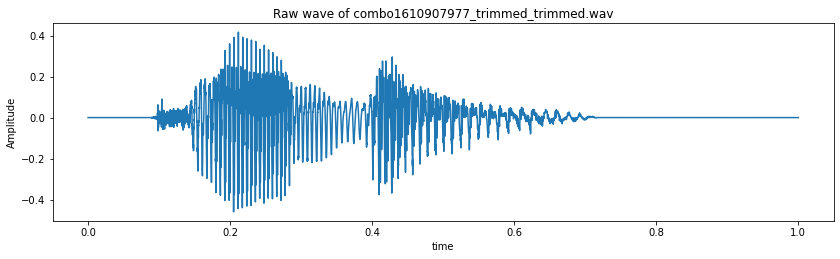

In [2]:
#Visualization of Audio signal in time series domain

train_audio_path = r'C:\Users\josep\Desktop\PythonApplication1\dest'
samples, sample_rate = librosa.load(train_audio_path+r'\combo\combo1610907977_trimmed_trimmed.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'combo1610907977_trimmed_trimmed.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [3]:
#Sampling rate
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)


16000


In [4]:
#resample to 8khz
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

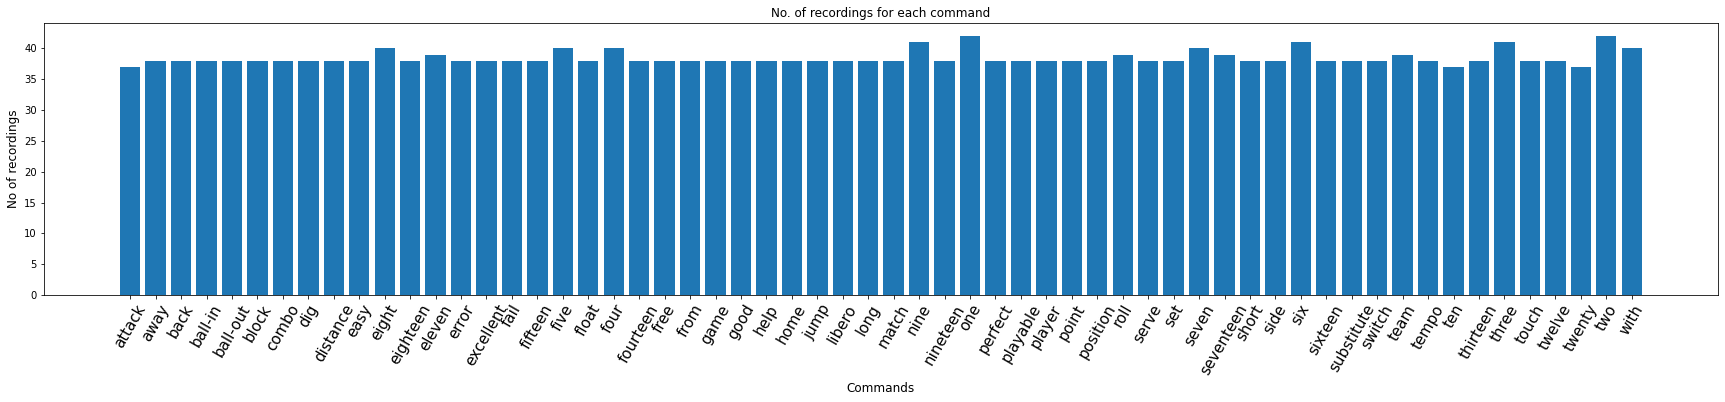

In [5]:
#the number of recordings for each voice command:
labels=os.listdir(train_audio_path)
 #find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

<ipython-input-6-e166773ff81b>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)


(array([3.000e+00, 4.000e+00, 1.000e+01, 2.000e+00, 5.000e+00, 9.000e+00,
        6.000e+00, 7.000e+00, 2.900e+01, 2.233e+03]),
 array([0.5573125 , 0.60158125, 0.64585   , 0.69011875, 0.7343875 ,
        0.77865625, 0.822925  , 0.86719375, 0.9114625 , 0.95573125,
        1.        ]),
 <a list of 10 Patch objects>)

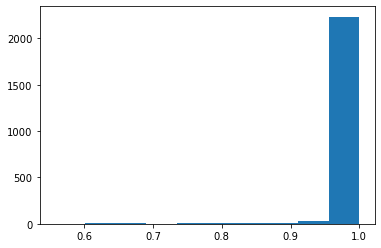

In [6]:
#duration of the records
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [7]:
config = tf.compat.v1.ConfigProto()
tf.compat.v1.GPUOptions.allow_growth = True
sess = tf.compat.v1.Session(config=config)

warnings.filterwarnings("ignore")

# Subsample
labels = [
		'one',
        "ten",
        "substitute",
        "short",
        "long",
        "side",
        "switch",
        "eleven",
        "twelve",
        "thirteen",
        "fourteen",
        "two",
        "fifteen",
        "sixteen",
        "seventeen",
        "eighteen",
        "nineteen",
        "twenty",
        "libero",
        "back",
        "free",
        "easy",
        "three",
        "combo",
        "position",
        "from",
        "distance",
        "tempo",
        "with",
        "player",
        "team",
        "home",
        "away",
        "four",
        "perfect",
        "excellent",
        "good",
        "playable",
        "fail",
        "error",
        "serve",
        "float",
        "roll",
        "jump",
        "five",
        "dig",
        "block",
        "touch",
        "attack",
        "ball-out",
        "ball-in",
        "help",
        "point",
        "game",
        "set",
        "six",
        "match",
        "seven",
        "eight",
        "nine"]

train_audio_path = r'C:\Users\josep\Desktop\PythonApplication1\dest'

all_wave = []
all_label = []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

100%|██████████| 60/60 [00:39<00:00,  1.52it/s]


In [8]:
#Convert the output labels to integer encoded:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label_enconder = LabelEncoder()
y = label_enconder.fit_transform(all_label)
classes = list(label_enconder.classes_)
y = np_utils.to_categorical(y, num_classes=len(labels))

In [9]:
#Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [10]:
#Split into train and validation set
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [11]:
#Model Architecture

from keras.layers import Bidirectional, BatchNormalization, GRU, TimeDistributed

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(inputs)

#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

x = Bidirectional(GRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(128, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(128, return_sequences=False), merge_mode='sum')(x)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

#Flatten layer
x = Flatten()(x)

#Dense Layer 1
x = Dense(61, activation='relu')(x)
outputs = Dense(len(labels), activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)          

In [13]:
#Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [14]:
#Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('speech2text_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

In [15]:
#Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

hist = model.fit(
    x=x_train, 
    y=y_train,
    epochs=100, 
    callbacks=[early_stop, checkpoint], 
    batch_size=32, 
    validation_data=(x_valid,y_valid)
)

Epoch 1/100
55/55 [==============================] - 44s 796ms/step - loss: 3.9642 - accuracy: 0.0333 - val_loss: 4.0941 - val_accuracy: 0.0183
Epoch 2/100
55/55 [==============================] - 45s 810ms/step - loss: 3.5105 - accuracy: 0.0797 - val_loss: 4.3386 - val_accuracy: 0.0183
Epoch 3/100
55/55 [==============================] - 45s 817ms/step - loss: 2.8931 - accuracy: 0.1651 - val_loss: 4.3343 - val_accuracy: 0.0183
Epoch 4/100
55/55 [==============================] - 45s 812ms/step - loss: 2.4092 - accuracy: 0.2534 - val_loss: 5.6931 - val_accuracy: 0.0115
Epoch 5/100
55/55 [==============================] - 44s 809ms/step - loss: 2.0249 - accuracy: 0.3417 - val_loss: 5.0170 - val_accuracy: 0.0298
Epoch 6/100
55/55 [==============================] - 45s 813ms/step - loss: 1.7126 - accuracy: 0.4587 - val_loss: 6.9429 - val_accuracy: 0.0206
Epoch 7/100
55/55 [==============================] - 45s 809ms/step - loss: 1.4615 - accuracy: 0.5218 - val_loss: 5.8212 - val_accuracy:

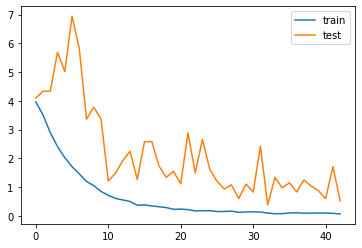

In [16]:
#Diagnostic plot

from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [17]:
#Save or Loading the best model¶
model.save('speech2text_model.hdf5')

In [18]:
from keras.models import load_model
model = load_model('speech2text_model.hdf5')

In [19]:
#Define the function that predicts text for the given audio:
def s2t_predict(audio, shape_num=8000):
    prob=model.predict(audio.reshape(1,shape_num,1))
    index=np.argmax(prob[0])
    return classes[index]


In [54]:
#Prediction time! Make predictions on the validation data:

import random
index=random.randint(0,len(x_valid)-1)
samples=x_valid[index].ravel()
print("Audio:",classes[np.argmax(y_valid[index])])
ipd.Audio(samples, rate=8000)

Audio: from


In [55]:
samples.shape

(8000,)

In [56]:
print("Text:",s2t_predict(samples))

Text: from


In [57]:
from scipy.io.wavfile import read as read_wav
import os
os.chdir(r'C:\Users\josep\Desktop\PythonApplication1\sample_AI2')
samplerate,data=read_wav("ball-in.wav")
print (samplerate)

16000


In [58]:
#reading the voice commands
test, test_rate = librosa.load(r'C:\Users\josep\Desktop\PythonApplication1\sample_AI2\ball-in.wav', sr = 16000)
test_sample = librosa.resample(test, test_rate, 8000)
print(test_sample.shape)
ipd.Audio(test_sample,rate=8000)

(8000,)


In [59]:
#converting voice commands to text
s2t_predict(test_sample)

'ball-in'

In [60]:
from pydub import AudioSegment
from pydub.utils import make_chunks

myaudio = AudioSegment.from_file(r"C:\Users\josep\Desktop\PythonApplication1\sample_AI2\sample1.wav" , "wav") 
chunk_length_ms = 1000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

#Export all of the individual chunks as wav files

for i, chunk in enumerate(chunks):
    chunk_name = r"C:\Users\josep\Desktop\PythonApplication1\sample_AI2\chunk{0}.wav".format(i)
    #print ("exporting", chunk_name)
    chunk.export(chunk_name, format="wav")

In [61]:
for i,chunk in enumerate(chunks):
    test, test_rate = librosa.load(r'C:\Users\josep\Desktop\PythonApplication1\sample_AI2\chunk'+str(i)+'.wav', sr = 16000)
    test_sample = librosa.resample(test, test_rate, 8000)
    #print(test_sample.shape)
    ipd.Audio(test_sample,rate=8000)
    #s2t_predict(test_sample)
    print(s2t_predict(test_sample))

good
game
away
team


In [24]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end
